# 小波变换

## 介绍
对于不稳定的信号，难以用普通的FFT分析出频域随时间变化的信息。所以对于不同时间段的频域函数进行分析，利用小波作为基函数，各个小波函数按照不同比例系数展开得到的，其中小波函数可更改中心频率和带宽。

## 操作
将欧拉函数置换成小波函数，小波函数随着原信号会发生变化。

小波变换公式：
$$F(τ,s) = \frac{1}{\sqrt{|s|}} \int_{-\infty}^{\infty} f(t) ψ^*(\frac{t-τ}{s}) dt$$

## STFT与小波变换对比

**STFT分析的窗函数是固定时长，相同窗长分帧的过程使频率分辨率就会降低。因分帧也就是加窗的过程，由于窗函数长度有限的，会造成截断。窗函数长，则时间分辨率低，而频率分辨率高；窗函数短，则频率分辨率低，而时间分辨率高。**

**小波变换通过更改小波函数的常宽，设置不同的基频，因此不同频段利用不同的分辨率。**

**在低频成分用高的频率分辨率；高频成分用高的时间分辨率。**

In [32]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy import signal
import matplotlib.pyplot as plt

In [55]:
# 音频文件路径
audio_file = r'E:\数据集\ShipEar\data_preprocessing\3_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav'

waveform, sample_rate = librosa.load(audio_file, sr=22050)

In [56]:
def plot_wavelet_transform(waveform, sample_rate, cA, cD, reconstructed_signal, figsize, wavelet_name):
    """
    绘制小波变换分析结果
    
    参数:
    waveform (numpy.ndarray): 原始音频信号
    sample_rate (int): 采样率
    cA (numpy.ndarray): 近似系数（低频成分）
    cD (numpy.ndarray): 细节系数（高频成分）
    reconstructed_signal (numpy.ndarray, optional): 重构信号
    figsize (tuple): 图形尺寸，默认(12, 8)
    wavelet_name (str): 小波名称，用于标题显示
    
    返回:
    matplotlib.figure.Figure: 图形对象
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 计算时间轴
    t = np.arange(len(waveform)) / sample_rate
    
    # 确定子图数量
    num_subplots = 4 if reconstructed_signal is not None else 3
    
    # 创建图形和子图
    fig, axes = plt.subplots(num_subplots, 1, figsize=figsize)
    
    # 绘制原始信号
    axes[0].plot(t, waveform)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title('Original Signal')
    
    # 绘制近似系数（低频成分）
    axes[1].plot(cA, color='blue')
    axes[1].set_xlabel('Samples')
    axes[1].set_ylabel('cA')
    axes[1].set_title(f'Approximate Coeff (cA) - {wavelet_name}')
    
    # 绘制细节系数（高频成分）
    axes[2].plot(cD, color='red')
    axes[2].set_xlabel('Samples')
    axes[2].set_ylabel('cD')
    axes[2].set_title(f'Detail Coeff (cD) - {wavelet_name}')
    
    # 如果提供了重构信号，绘制第四个子图
    if reconstructed_signal is not None:
        t_reconstructed = np.arange(len(reconstructed_signal)) / sample_rate
        axes[3].plot(t_reconstructed, reconstructed_signal, color='green')
        axes[3].set_xlabel('Time (s)')
        axes[3].set_ylabel('Amplitude')
        axes[3].set_title('Reconstructed Signal')
    
    # 调整子图间距
    plt.tight_layout()
    plt.show()

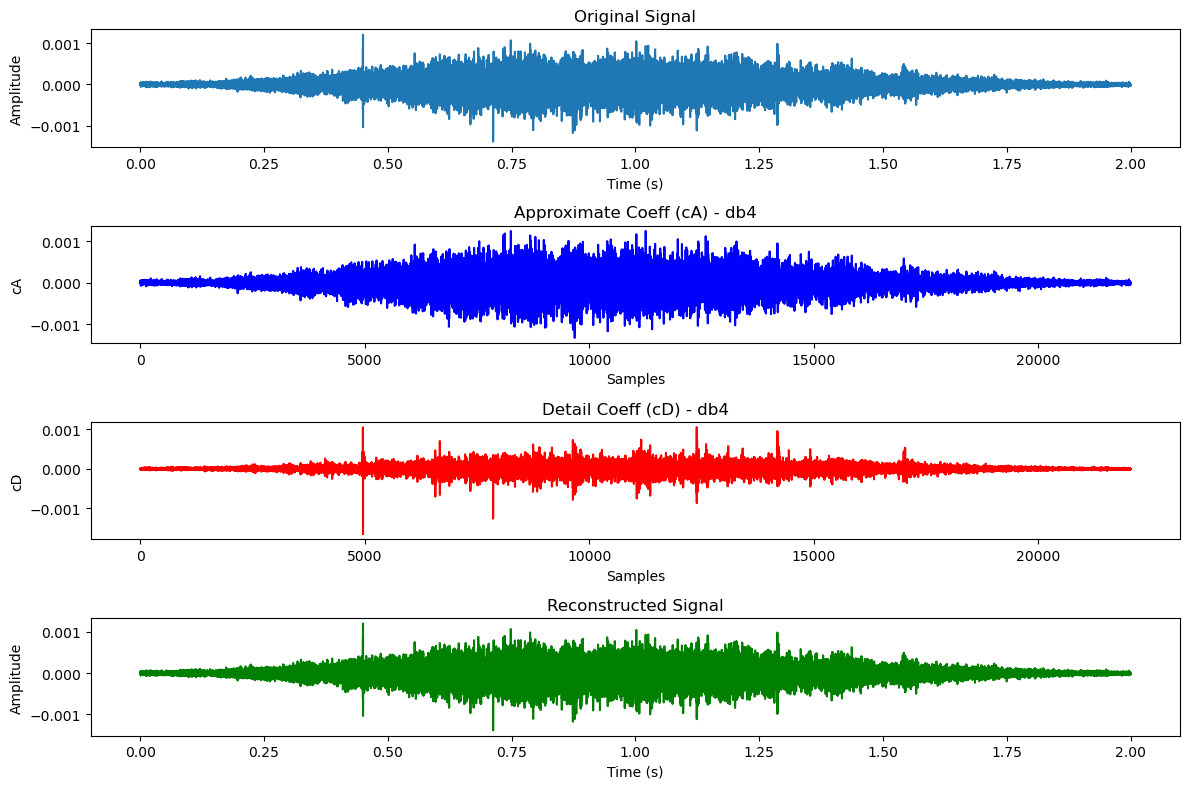

In [57]:
t = np.arange(len(waveform)) / sample_rate

# cA ：近似系数（低频成分），保留信号的主要趋势
# cD ：细节系数（高频成分），捕获信号的细节和突变
cA, cD = pywt.dwt(waveform, 'db4')

# 重构信号
y = pywt.idwt(cA, cD, 'db4')

plot_wavelet_transform(
    waveform=waveform,
    sample_rate=sample_rate, 
    cA=cA,
    cD=cD,
    reconstructed_signal=y,  # 如果没有重构信号，可以传入None
    figsize=(12, 8),
    wavelet_name='db4'
)

In [69]:
def wavelet_denoising(waveform, wavelet='db4', levels=3, threshold_mode='soft'):
    """
    使用小波变换进行信号去噪。

    参数:
    waveform (numpy.ndarray): 输入音频信号。
    wavelet (str): 小波基函数名称。
    levels (int): 分解层数。
    threshold_mode (str): 阈值处理模式，'soft' 或 'hard'。

    返回:
    numpy.ndarray: 去噪后的音频信号。
    """
    # 小波分解
    coeffs = pywt.wavedec(waveform, wavelet, level=levels)
    
    # 估计噪声标准差（使用最高频细节系数）
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    
    # 计算阈值
    threshold = sigma * np.sqrt(2 * np.log(len(waveform)))
    
    # 对细节系数进行阈值处理
    coeffs_thresh = list(coeffs)
    coeffs_thresh[1:] = [pywt.threshold(detail, threshold, threshold_mode) 
                         for detail in coeffs[1:]]
    
    # 重构信号
    denoised_signal = pywt.waverec(coeffs_thresh, wavelet)
    
    return denoised_signal

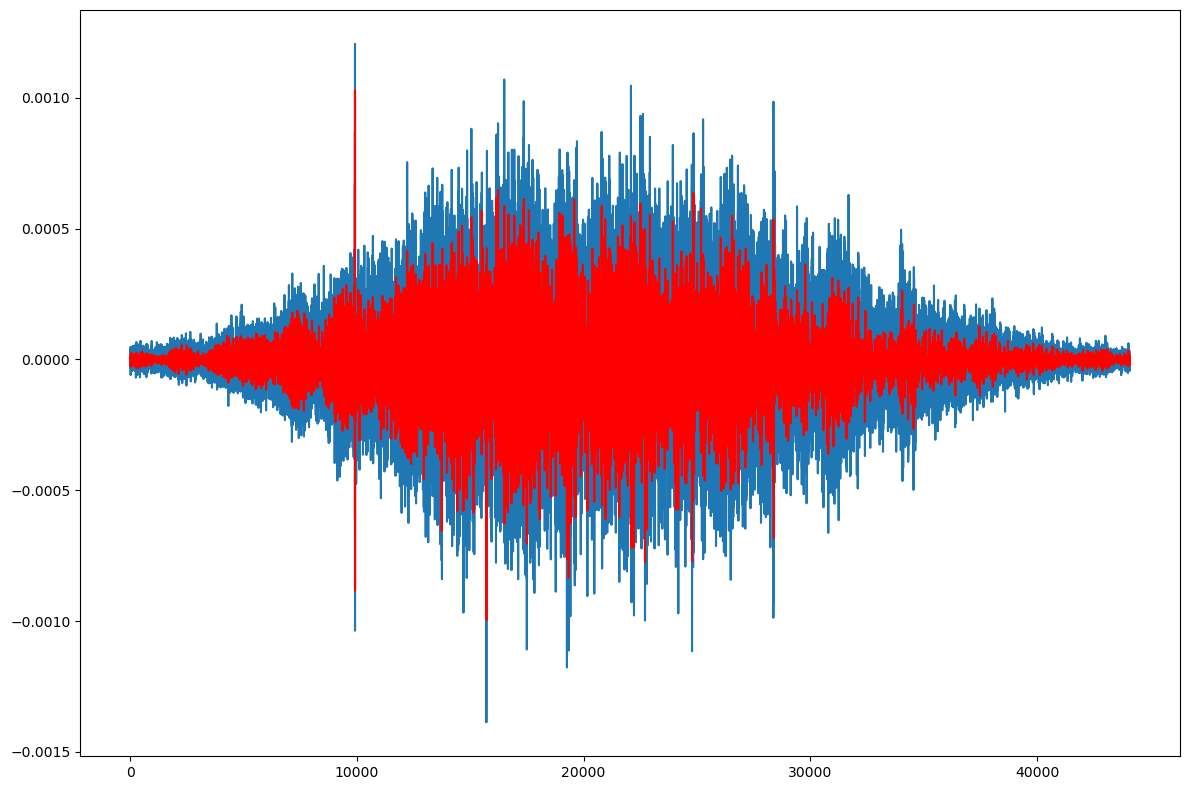

In [70]:
waveform_denoise = wavelet_denoising(waveform)
plt.figure(figsize=(12, 8))
plt.plot(waveform)
plt.plot(waveform_denoise, c='r')
plt.tight_layout()
plt.show()

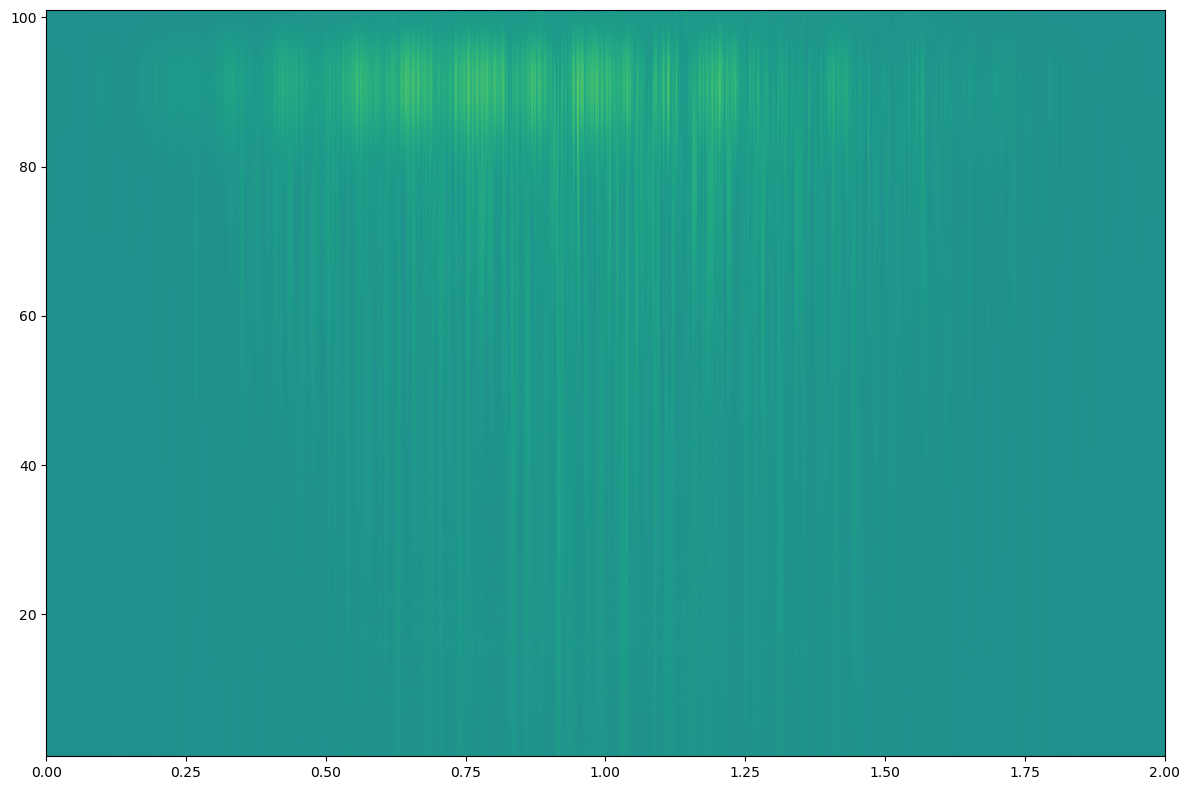

In [87]:
t = np.arange(len(waveform)) / sample_rate

coef, freq = pywt.cwt(waveform, np.arange(1, 101), 'gaus1')

plt.figure(figsize=(12, 8))
plt.imshow(abs(coef), extent=[0, 2, 1, 101],interpolation='bilinear', aspect='auto', vmax=abs(coef).max(), vmin=-abs(coef).max())
plt.tight_layout()
plt.show()

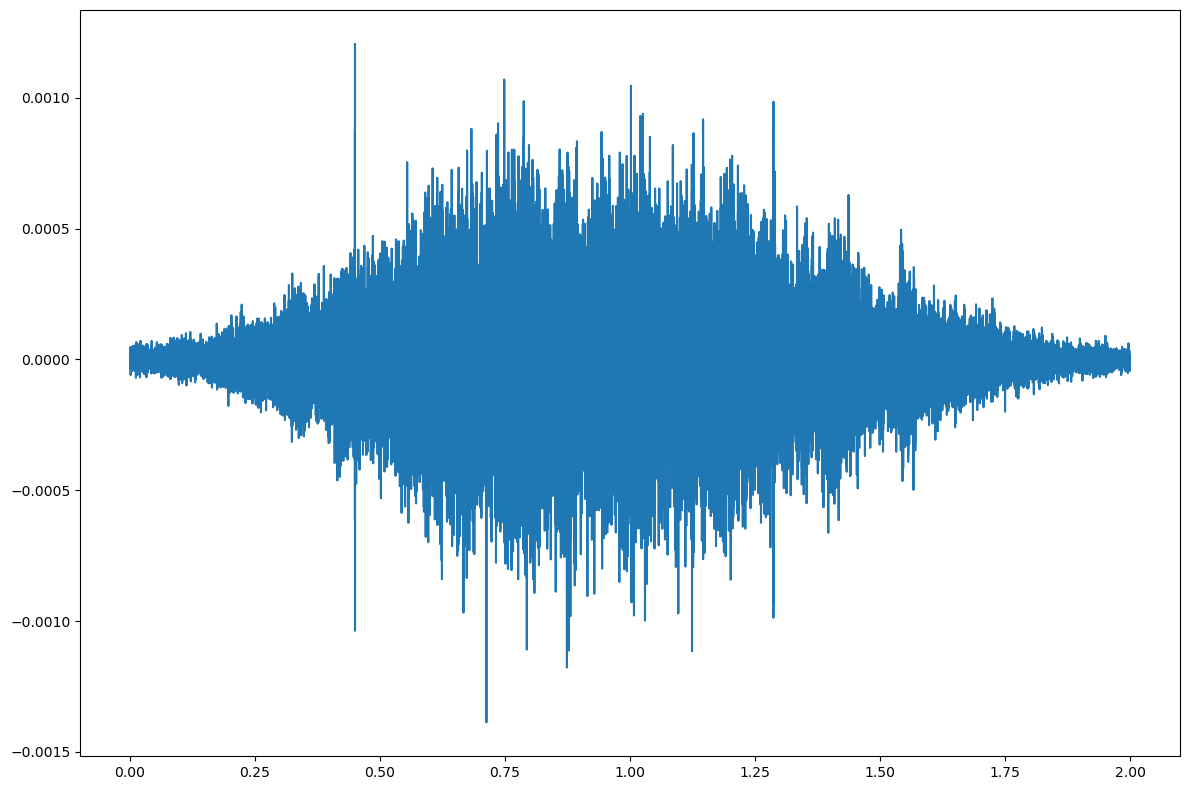

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(t, waveform)
plt.tight_layout()
plt.show()